# vision analysis 

This script analyzes the impact of differences in language on visual representations. In particular we look at the RSA scores between agents visual representations and symbolic encodings of the input objects or only specific object attributes. In addition, we look at the RSA score between sender and receiver representations before and after communication. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from utils.bootstrap_ci import bootstrap_mean, bootstrap_mean_difference
from matplotlib.ticker import StrMethodFormatter

# train vision with additional classification loss 

## load RSA scores into data frame

In [7]:
setups = ['learning', 'emergence-default-receiver', 'emergence-default-sender']

conditions = ['default', 'color', 'scale', 'shape', 'all']
vs = 4
nruns = 10
modes = ['language_learning_train_vision',
         'language_emergence_train_vision', 
         'language_emergence_train_vision']

rsa_agent_input = {'attribute':[], 'value':[], 'condition': [], 'setup': []}
rsa_sender_receiver = {'condition':[], 'training_status': [], 'value':[], 'setup': []}

for i, setup in enumerate(setups): 
    if setup == 'learning': 
        agent = 'receiver'
        load_conditions = [conditions[i] + '_default' for i in range(len(conditions))]
    elif setup == 'emergence-default-receiver': 
        agent = 'receiver'
        load_conditions = ['default'] + [conditions[i] + '_default' for i in range(1,len(conditions))]
    elif setup == 'emergence-default-sender':
        agent = 'sender'
        load_conditions = ['default'] + ['default_' + conditions[i] for i in range(1,len(conditions))]
    for c, condition in enumerate(conditions): 
        for r in range(nruns): 
            scores = pickle.load(
                open('results/' + modes[i] + '/' + load_conditions[c] + str(r) + '/vs' + str(vs) + 
                     '_ml3/correlated_similarity_vision.pkl', 'rb')
            )
            rsa_agent_input['setup']+= [setup]*4
            rsa_agent_input['condition'] += [condition]*4
            rsa_agent_input['attribute'].append('all')
            rsa_agent_input['value'].append(scores['rsa_' + agent + '_attributes'])
            for bias in ['color', 'scale', 'shape']: 
                rsa_agent_input['attribute'].append(bias)
                rsa_agent_input['value'].append(scores['rsa_' + agent + '_' + bias])
            rsa_sender_receiver['condition'] += [condition]*2
            rsa_sender_receiver['setup'] += [setup]*2
            rsa_sender_receiver['training_status'].append('original')
            rsa_sender_receiver['value'].append(scores['rsa_sender_receiver_orig'])
            rsa_sender_receiver['training_status'].append('trained')
            rsa_sender_receiver['value'].append(scores['rsa_sender_receiver_trained'])
            
rsa_sender_receiver = pd.DataFrame(data=rsa_sender_receiver)
rsa_agent_input = pd.DataFrame(data=rsa_agent_input)

## plot RSA scores

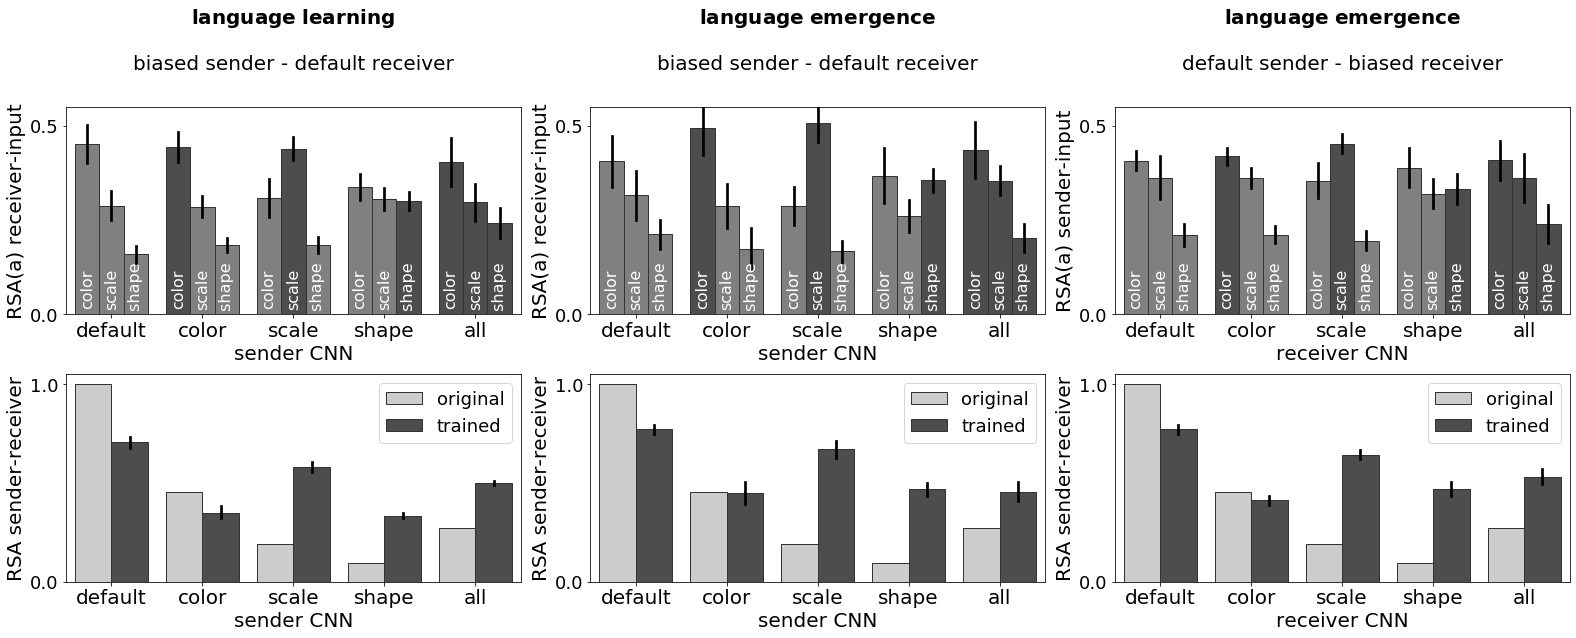

In [8]:
size = (22,9)
fontsize=20

plt.figure(figsize=size)

for s, setup in enumerate(setups): 
    
    plt.subplot(2,3,s+1)
    
    p = sns.barplot(x='condition', y='value', hue='attribute', ci='sd', #
                data=rsa_agent_input[(rsa_agent_input.attribute!='all') & (rsa_agent_input.setup==setup)])
    plt.xlabel(['sender CNN', 'sender CNN', 'receiver CNN'][s], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks([0.0,0.5], fontsize=fontsize-2)
    plt.ylim([0.0,0.55])
    plt.ylabel(['RSA(a) receiver-input', 'RSA(a) receiver-input', 'RSA(a) sender-input'][s], fontsize=fontsize)
    plt.title([r"$\mathbf{language\;learning}$" + '\n\nbiased sender - default receiver', 
               r"$\mathbf{language\;emergence}$" + '\n\nbiased sender - default receiver', 
               r"$\mathbf{language\;emergence}$" + '\n\ndefault sender - biased receiver'][s],
              fontsize=fontsize, x=0.5, y=1.15)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

    darkgray = [0.3,0.3,0.3]
    gray = [0.5,0.5,0.5]
    labels = ['color']*5 + ['scale']*5 + [' shape']*5
    for k, patch in enumerate(p.patches): 
        p.annotate(labels[k],
                   (patch.get_x() + patch.get_width() / 2., 0.2), 
                   ha = 'center', va = 'center', 
                   size=16,
                   #weight='bold',
                   xytext = (0, -50), 
                   color=[1,1,1],
                   textcoords = 'offset points', 
                   rotation='vertical'
                  )
        patch.set_color([gray, darkgray, gray, gray, darkgray, 
                         gray, gray, darkgray, gray, darkgray, 
                         gray, gray, gray, darkgray, darkgray][k])
        patch.set_edgecolor([0.2,0.2,0.2])

    for line in p.get_lines(): 
        line.set_color('k')
        
    p.legend_.remove()

    plt.subplot(2,3,s+4)
    p = sns.barplot(x='condition', y='value', hue='training_status', palette=[[g+0.3 for g in gray], darkgray],
                    data=rsa_sender_receiver[rsa_sender_receiver.setup==setup])
    for patch in p.patches: 
        patch.set_edgecolor([0.2,0.2,0.2])
    plt.xlabel(['sender CNN', 'sender CNN', 'receiver CNN'][s], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks([0.0,1.0], fontsize=fontsize-2)
    plt.ylabel('RSA sender-receiver', fontsize=fontsize)
    for line in p.get_lines(): 
        line.set_color('k')
    legend = plt.legend(fontsize=fontsize-2)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

plt.tight_layout()

## compare settings and biases

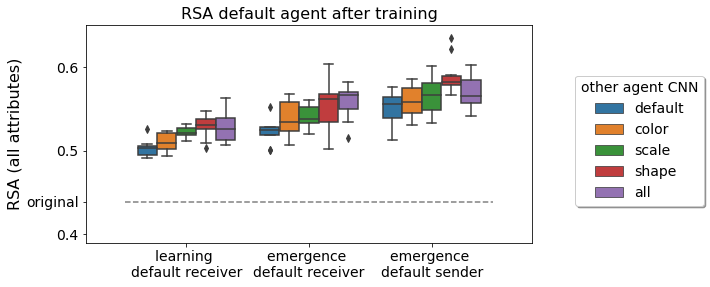

In [12]:
fontsize = 16
plt.figure(figsize=(8,4))

data = rsa_agent_input[rsa_agent_input.attribute=='all']
ax = sns.boxplot(x="setup", y="value", hue="condition", data=data)
ax.set_xlabel('')
ax.set_xticklabels(['learning \ndefault receiver', 'emergence \ndefault receiver', 'emergence \ndefault sender'], 
                   fontsize=fontsize-2)
ax.set_ylabel('RSA (all attributes)', fontsize=fontsize)
plt.hlines(0.4390, -0.5, 2.5, linestyle='--', color='gray')
plt.yticks(ticks=[0.4, 0.4390,0.5, 0.6], labels=[0.4, 'original', 0.5, 0.6], fontsize=fontsize-2)
plt.ylim([0.39, 0.65])
legend = plt.legend(fontsize=fontsize-2, loc='upper right', bbox_to_anchor=(1.4, 0.8), fancybox=True, shadow=True, 
                    title='other agent CNN')
legend.get_title().set_fontsize(fontsize-2)
plt.title('RSA default agent after training', fontsize=fontsize)
plt.show()

In [13]:
# mean per scenario

for scenario in ['learning', 'emergence-default-receiver', 'emergence-default-sender']:
    print(scenario, np.mean(rsa_agent_input[(rsa_agent_input.setup==scenario) &
                                            (rsa_agent_input.attribute=='all')])[0])

learning 0.5183041948402856
emergence-default-receiver 0.5429824017514135
emergence-default-sender 0.5665748290305145


In [13]:
# bootstrapped CIs for difference in means between settings

print('emergence - default receiver; learning',
    bootstrap_mean_difference(
    rsa_agent_input[(rsa_agent_input.attribute=='all') & (rsa_agent_input.setup==setups[1])].value,
    rsa_agent_input[(rsa_agent_input.attribute=='all') & (rsa_agent_input.setup==setups[0])].value
    )
)
print('emergence - default sender; emergence - default receiver',
    bootstrap_mean_difference(
        rsa_agent_input[(rsa_agent_input.attribute=='all') & (rsa_agent_input.setup==setups[2])].value,
        rsa_agent_input[(rsa_agent_input.attribute=='all') & (rsa_agent_input.setup==setups[1])].value
    )
)
print('emergence - default sender; learning',
    bootstrap_mean_difference(
        rsa_agent_input[(rsa_agent_input.attribute=='all') & (rsa_agent_input.setup==setups[2])].value,
        rsa_agent_input[(rsa_agent_input.attribute=='all') & (rsa_agent_input.setup==setups[0])].value
    )
)

emergence - default receiver; learning (0.0167259714995437, 0.032949902097751935)
emergence - default sender; emergence - default receiver (0.013954831490159513, 0.032839543621789945)
emergence - default sender; learning (0.040424616417953765, 0.056276653617478044)


In [15]:
# mean per scenario

for condition in ['default', 'color', 'scale', 'shape', 'all']:
    print(condition, np.mean(rsa_agent_input[(rsa_agent_input.condition==condition) &
                                             (rsa_agent_input.attribute=='all')])[0])

default 0.5254235053456359
color 0.5350644050396552
scale 0.5427716814971489
shape 0.5576010661822203
all 0.5522417179723621


In [15]:
# bootstrapped CIs for difference in means between 'default' and other conditions

for condition in ['color', 'scale', 'shape', 'all']: 
    print(condition + ' ; default',
          bootstrap_mean_difference(
              rsa_agent_input[(rsa_agent_input.attribute=='all') & (rsa_agent_input.condition==condition)].value,
              rsa_agent_input[(rsa_agent_input.attribute=='all') & (rsa_agent_input.condition=='default')].value
          )
         )

color ; default (-0.00313713044880651, 0.022349420368610165)
scale ; default (0.005719120765435666, 0.02950222594506153)
shape ; default (0.01718749886208831, 0.047119789072901576)
all ; default (0.013880068601914465, 0.03971488069764227)


# analysis: flexible-role agents

### load RSA scores into data frame

In [13]:
conditions = ['default', 'scale', 'all']
vs = 4
n_agents = 2
nruns = 10

rsa_agent_input = {'attribute':[], 'value':[], 'condition': []}
rsa_sender_receiver = {'condition':[], 'training_status': [], 'value':[]}


for c, condition in enumerate(conditions): 
    load_condition = 'default_' + condition
    for r in range(nruns): 
        scores = pickle.load(open('results/language_emergence_train_vision_flexible_role/' + load_condition + 
                                  str(r) + '/vs' + str(vs) + '_ml3/correlated_similarity_vision.pkl', 'rb'))
        
        rsa_agent_input['condition'] += [condition]*4
        
        rsa_agent_input['attribute'].append('all')
        rsa_agent_input['value'].append(scores['rsa_agent1_attributes'])
        for bias in ['color', 'scale', 'shape']: 
            rsa_agent_input['attribute'].append(bias)
            rsa_agent_input['value'].append(scores['rsa_agent1_' + bias])

        rsa_sender_receiver['condition'] += [condition]*2
        rsa_sender_receiver['training_status'].append('original')
        rsa_sender_receiver['value'].append(scores['rsa_agent1_agent2_orig'])
        rsa_sender_receiver['training_status'].append('trained')
        rsa_sender_receiver['value'].append(scores['rsa_agent1_agent2_trained'])
            
rsa_sender_receiver = pd.DataFrame(data=rsa_sender_receiver)
rsa_agent_input = pd.DataFrame(data=rsa_agent_input)

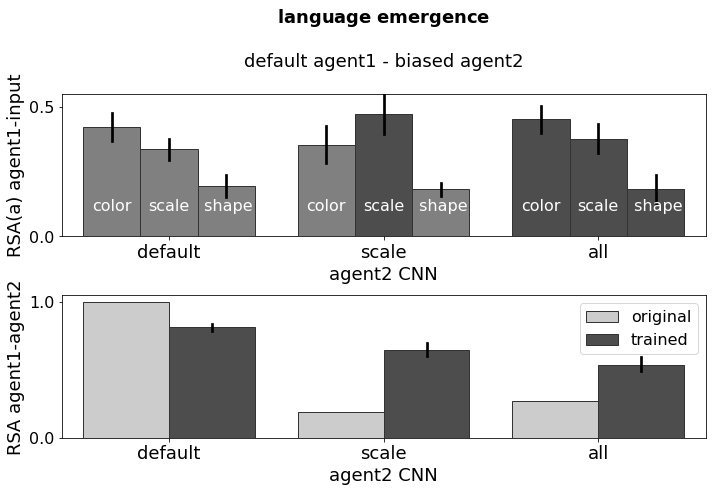

In [14]:
size = (10,7)
fontsize=18

plt.figure(figsize=size)
    
plt.subplot(2,1,1)

p = sns.barplot(x='condition', y='value', hue='attribute', ci='sd', 
                data=rsa_agent_input[(rsa_agent_input.attribute!='all')])
plt.xlabel('agent2 CNN', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks([0.0,0.5], fontsize=fontsize-2)
plt.ylim([0.0,0.55])
plt.ylabel('RSA(a) agent1-input', fontsize=fontsize)
plt.title(r"$\mathbf{language\;emergence}$" + '\n\ndefault agent1 - biased agent2', 
          fontsize=fontsize, x=0.5, y=1.15)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    
darkgray = [0.3,0.3,0.3]
gray = [0.5,0.5,0.5]
labels = ['color']*3 + ['scale']*3 + [' shape']*3
for k, patch in enumerate(p.patches): 
    p.annotate(labels[k],
               (patch.get_x() + patch.get_width() / 2., 0.31), 
               ha = 'center', va = 'center', 
               size=16,
               xytext = (0, -50), 
               color=[1,1,1],
               textcoords = 'offset points', 
               rotation='horizontal'
              )
    patch.set_color([gray, gray, darkgray,
                     gray, darkgray, darkgray,
                     gray, gray, darkgray][k])
    patch.set_edgecolor([0.2,0.2,0.2])

for line in p.get_lines(): 
    line.set_color('k')
    
p.legend_.remove()

plt.subplot(2,1,2)
p = sns.barplot(x='condition', y='value', hue='training_status', palette=[[g+0.3 for g in gray], darkgray],
                data=rsa_sender_receiver)
for patch in p.patches: 
    patch.set_edgecolor([0.2,0.2,0.2])
plt.xlabel('agent2 CNN', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks([0.0,1.0], fontsize=fontsize-2)
plt.ylabel('RSA agent1-agent2', fontsize=fontsize)
for line in p.get_lines(): 
    line.set_color('k')
legend = plt.legend(fontsize=fontsize-2)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

plt.tight_layout()

### compare settings and biases

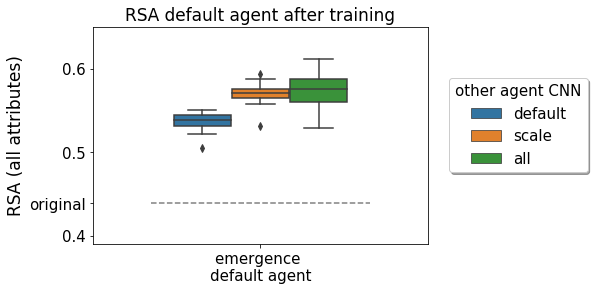

In [15]:
fontsize = 17
plt.figure(figsize=(6,4))

rsa_agent_input['setup'] = ['emergence-default']*len(rsa_agent_input)
data = rsa_agent_input[rsa_agent_input.attribute=='all']
ax = sns.boxplot(x='setup', y="value", hue="condition", data=data)
ax.set_xlabel('')
ax.set_xticklabels(['emergence \ndefault agent'], fontsize=fontsize-2)
ax.set_ylabel('RSA (all attributes)', fontsize=fontsize)
plt.hlines(0.4390, -0.5, 0.5, linestyle='--', color='gray')
plt.yticks(ticks=[0.4, 0.4390,0.5, 0.6], labels=[0.4, 'original', 0.5, 0.6], fontsize=fontsize-2)
plt.ylim([0.39, 0.65])
legend = plt.legend(fontsize=fontsize-2, loc='upper right', bbox_to_anchor=(1.5, 0.8), fancybox=True, shadow=True, 
                    title='other agent CNN')
legend.get_title().set_fontsize(fontsize-2)
plt.title('RSA default agent after training', fontsize=fontsize)
plt.show()

In [6]:
data.groupby('condition').mean()

,value
condition,
all,0.572180
default,0.535825
scale,0.569269


# analysis: two senders, two receivers

### load RSA scores into data frame

In [13]:
setups = ['emergence-default-receiver', 'emergence-default-sender']

conditions = ['default', 'scale', 'all']
vs = 4
n_agents = 2
nruns = 10
modes = ['language_emergence_train_vision_2senders-2receivers', 
         'language_emergence_train_vision_2senders-2receivers']

rsa_agent_input = {'attribute':[], 'value':[], 'condition': [], 'setup': []}
rsa_sender_receiver = {'condition':[], 'training_status': [], 'value':[], 'setup': []}

for i, setup in enumerate(setups): 
    if setup == 'emergence-default-receiver': 
        agent = 'receiver'
        load_conditions = [conditions[i] + '_default' for i in range(len(conditions))]
    elif setup == 'emergence-default-sender':
        agent = 'sender'
        load_conditions = ['default_' + conditions[i] for i in range(len(conditions))]
    for c, condition in enumerate(conditions): 
        for r in range(nruns): 
            scores = pickle.load(
                open('results/' + modes[i] + '/' + load_conditions[c] + str(r) + '/vs' + str(vs) + 
                     '_ml3/correlated_similarity_vision.pkl', 'rb')
            )
            
            rsa_agent_input['setup']+= [setup]*4
            rsa_agent_input['condition'] += [condition]*4
            
            rsa_agent_input['attribute'].append('all')
            rsa_agent_input['value'].append(
                np.mean([scores['rsa_' + agent + str(i) + '_attributes'] for i in range(n_agents)])
            )
            for bias in ['color', 'scale', 'shape']: 
                rsa_agent_input['attribute'].append(bias)
                rsa_agent_input['value'].append(
                    np.mean([scores['rsa_' + agent + str(i) + '_' + bias] for i in range(n_agents)])
                )
            rsa_sender_receiver['condition'] += [condition]*2
            rsa_sender_receiver['setup'] += [setup]*2
            rsa_sender_receiver['training_status'].append('original')
            rsa_sender_receiver['value'].append(scores['rsa_sender_receiver_orig'])
            rsa_sender_receiver['training_status'].append('trained')
            rsa_sender_receiver['value'].append(
                np.mean([scores['rsa_sender' + str(i) + '_receiver' + str(j) + '_trained'] 
                         for i in range(n_agents) for j in range(n_agents)])
            )
            
rsa_sender_receiver = pd.DataFrame(data=rsa_sender_receiver)
rsa_agent_input = pd.DataFrame(data=rsa_agent_input)

### plot RSA scores

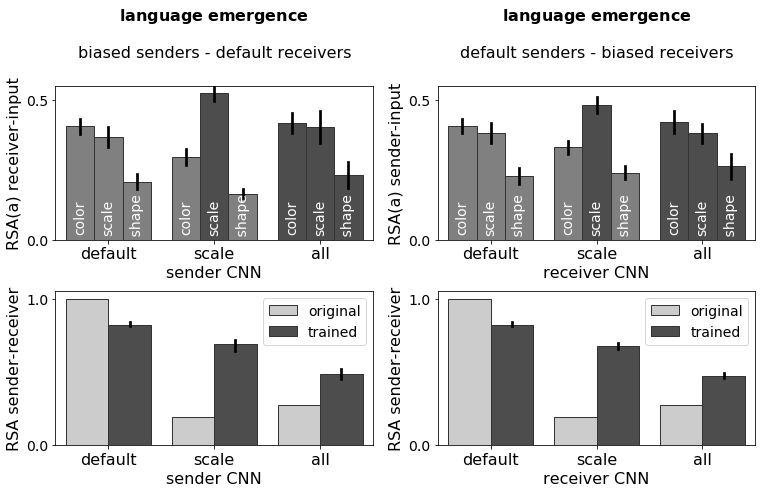

In [14]:
size = (16,7)
fontsize=16

plt.figure(figsize=size)

for s, setup in enumerate(setups): 
    
    plt.subplot(2,3,s+1)
    
    p = sns.barplot(x='condition', y='value', hue='attribute', ci='sd', 
                    data=rsa_agent_input[(rsa_agent_input.attribute!='all') & (rsa_agent_input.setup==setup)])
    plt.xlabel(['sender CNN', 'receiver CNN'][s], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks([0.0,0.5], fontsize=fontsize-2)
    plt.ylim([0.0,0.55])
    plt.ylabel(['RSA(a) receiver-input', 'RSA(a) sender-input'][s], fontsize=fontsize)
    plt.title([r"$\mathbf{language\;emergence}$" + '\n\nbiased senders - default receivers', 
               r"$\mathbf{language\;emergence}$" + '\n\ndefault senders - biased receivers'][s],
              fontsize=fontsize, x=0.5, y=1.15)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
        
    darkgray = [0.3,0.3,0.3]
    gray = [0.5,0.5,0.5]
    labels = ['color']*3 + ['scale']*3 + [' shape']*3
    for k, patch in enumerate(p.patches): 
        p.annotate(labels[k],
                   (patch.get_x() + patch.get_width() / 2., 0.26), 
                   ha = 'center', va = 'center', 
                   size=14,
                   xytext = (0, -50), 
                   color=[1,1,1],
                   textcoords = 'offset points', 
                   rotation='vertical'
                  )
        patch.set_color([gray, gray, darkgray,
                         gray, darkgray, darkgray,
                         gray, gray, darkgray][k])
        patch.set_edgecolor([0.2,0.2,0.2])

    for line in p.get_lines(): 
        line.set_color('k')
        
    p.legend_.remove()

    plt.subplot(2,3,s+4)
    p = sns.barplot(x='condition', y='value', hue='training_status', palette=[[g+0.3 for g in gray], darkgray],
                    data=rsa_sender_receiver[rsa_sender_receiver.setup==setup])
    for patch in p.patches: 
        patch.set_edgecolor([0.2,0.2,0.2])
    plt.xlabel(['sender CNN', 'receiver CNN'][s], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks([0.0,1.0], fontsize=fontsize-2)
    plt.ylabel('RSA sender-receiver', fontsize=fontsize)
    for line in p.get_lines(): 
        line.set_color('k')
    legend = plt.legend(fontsize=fontsize-2)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

plt.tight_layout()

### compare settings and biases

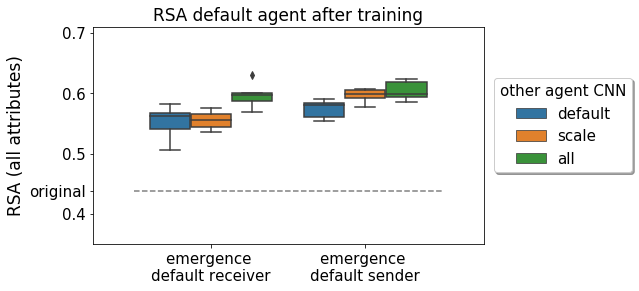

In [18]:
fontsize = 17
plt.figure(figsize=(7,4))

data = rsa_agent_input[rsa_agent_input.attribute=='all']
ax = sns.boxplot(x="setup", y="value", hue="condition", data=data)
ax.set_xlabel('')
ax.set_xticklabels(['emergence \ndefault receiver', 'emergence \ndefault sender'], fontsize=fontsize-2)
ax.set_ylabel('RSA (all attributes)', fontsize=fontsize)
plt.hlines(0.4390, -0.5, 1.5, linestyle='--', color='gray')
plt.yticks(ticks=[0.4, 0.4390,0.5, 0.6, 0.7], labels=[0.4, 'original', 0.5, 0.6, 0.7], fontsize=fontsize-2)
plt.ylim([0.35, 0.71])
legend = plt.legend(fontsize=fontsize-2, loc='upper right', bbox_to_anchor=(1.4, 0.8), fancybox=True, shadow=True, 
                    title='other agent CNN')
legend.get_title().set_fontsize(fontsize-2)
plt.title('RSA default agent after training', fontsize=fontsize)
plt.show()

In [12]:
data[data.setup=='emergence-default-receiver'].groupby('condition').mean()

,value
condition,
all,0.595425
default,0.553182
scale,0.555909


In [13]:
data[data.setup=='emergence-default-sender'].groupby('condition').mean()

,value
condition,
all,0.604407
default,0.574179
scale,0.596919


# analysis: train vision without additional classification loss 

### load RSA scores into data frame

In [2]:
setups = ['learning', 'emergence-default-receiver', 'emergence-default-sender']

conditions = ['default', 'scale', 'all']
vs = 4
nruns = 10
modes = ['language_learning_train_vision_no_classification',
         'language_emergence_train_vision_no_classification', 
         'language_emergence_train_vision_no_classification']

rsa_agent_input = {'attribute':[], 'value':[], 'condition': [], 'setup': []}
rsa_sender_receiver = {'condition':[], 'training_status': [], 'value':[], 'setup': []}

for i, setup in enumerate(setups): 
    if setup == 'learning': 
        agent = 'receiver'
        load_conditions = [conditions[i] + '_default' for i in range(len(conditions))]
    elif setup == 'emergence-default-receiver': 
        agent = 'receiver'
        load_conditions = [conditions[i] + '_default' for i in range(len(conditions))]
    elif setup == 'emergence-default-sender':
        agent = 'sender'
        load_conditions = ['default_' + conditions[i] for i in range(len(conditions))]
    for c, condition in enumerate(conditions): 
        for r in range(nruns): 
            scores = pickle.load(
                open('results/' + modes[i] + '/' + load_conditions[c] + str(r) + '/vs' + str(vs) + 
                     '_ml3/correlated_similarity_vision.pkl', 'rb')
            )
            rsa_agent_input['setup']+= [setup]*4
            rsa_agent_input['condition'] += [condition]*4
            rsa_agent_input['attribute'].append('all')
            rsa_agent_input['value'].append(scores['rsa_' + agent + '_attributes'])
            for bias in ['color', 'scale', 'shape']: 
                rsa_agent_input['attribute'].append(bias)
                rsa_agent_input['value'].append(scores['rsa_' + agent + '_' + bias])
            rsa_sender_receiver['condition'] += [condition]*2
            rsa_sender_receiver['setup'] += [setup]*2
            rsa_sender_receiver['training_status'].append('original')
            rsa_sender_receiver['value'].append(scores['rsa_sender_receiver_orig'])
            rsa_sender_receiver['training_status'].append('trained')
            rsa_sender_receiver['value'].append(scores['rsa_sender_receiver_trained'])
            
rsa_sender_receiver = pd.DataFrame(data=rsa_sender_receiver)
rsa_agent_input = pd.DataFrame(data=rsa_agent_input)

### plot RSA scores

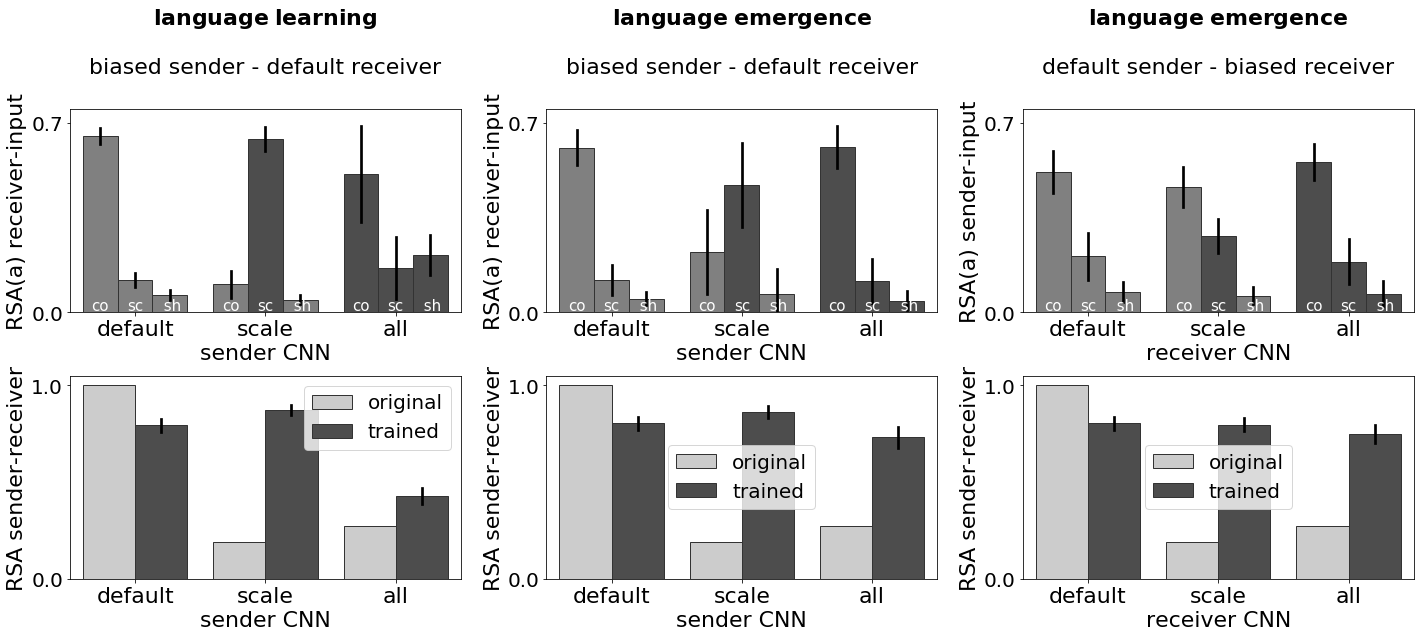

In [9]:
size = (20,9)
fontsize=22

plt.figure(figsize=size)
darkgray = [0.3,0.3,0.3]
gray = [0.5,0.5,0.5]

for s, setup in enumerate(setups): 
    
    plt.subplot(2,3,s+1)
    
    p = sns.barplot(x='condition', y='value', hue='attribute', ci='sd', #
                data=rsa_agent_input[(rsa_agent_input.attribute!='all') & (rsa_agent_input.setup==setup)])
    plt.xlabel(['sender CNN', 'sender CNN', 'receiver CNN'][s], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks([0.0,0.7], fontsize=fontsize-2)
    plt.ylim([0.0,0.75])
    plt.ylabel(['RSA(a) receiver-input', 'RSA(a) receiver-input', 'RSA(a) sender-input'][s], fontsize=fontsize)
    plt.title([r"$\mathbf{language\;learning}$" + '\n\nbiased sender - default receiver', 
               r"$\mathbf{language\;emergence}$" + '\n\nbiased sender - default receiver', 
               r"$\mathbf{language\;emergence}$" + '\n\ndefault sender - biased receiver'][s],
              fontsize=fontsize, x=0.5, y=1.15)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    
    labels = ['co']*3 + ['sc']*3 + [' sh']*3
    for k, patch in enumerate(p.patches): 
        p.annotate(labels[k],
                   (patch.get_x() + patch.get_width() / 2., 0.21), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -50), 
                   color=[1,1,1],
                   textcoords = 'offset points', 
                   rotation='horizontal'
                  )
        patch.set_color([gray, gray, darkgray,
                         gray, darkgray, darkgray,
                         gray, gray, darkgray][k])
        patch.set_edgecolor([0.2,0.2,0.2])

    for line in p.get_lines(): 
        line.set_color('k')
        
    p.legend_.remove()

    plt.subplot(2,3,s+4)
    p = sns.barplot(x='condition', y='value', hue='training_status', palette=[[g+0.3 for g in gray], darkgray],
                    data=rsa_sender_receiver[rsa_sender_receiver.setup==setup])
    for patch in p.patches: 
        patch.set_edgecolor([0.2,0.2,0.2])
    plt.xlabel(['sender CNN', 'sender CNN', 'receiver CNN'][s], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks([0.0,1.0], fontsize=fontsize-2)
    plt.ylabel('RSA sender-receiver', fontsize=fontsize)
    for line in p.get_lines(): 
        line.set_color('k')
    legend = plt.legend(fontsize=fontsize-2)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

plt.tight_layout()

### compare settings and biases

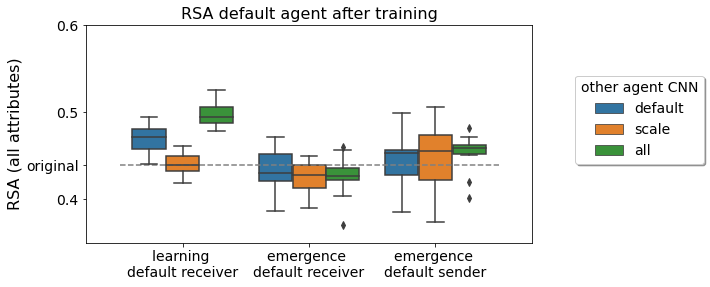

In [24]:
fontsize = 16
plt.figure(figsize=(8,4))

data = rsa_agent_input[rsa_agent_input.attribute=='all']
ax = sns.boxplot(x="setup", y="value", hue="condition", data=data)
ax.set_xlabel('')
ax.set_xticklabels(['learning \ndefault receiver', 'emergence \ndefault receiver', 'emergence \ndefault sender'], 
                   fontsize=fontsize-2)
ax.set_ylabel('RSA (all attributes)', fontsize=fontsize)
plt.hlines(0.4390, -0.5, 2.5, linestyle='--', color='gray')
plt.yticks(ticks=[0.4, 0.4390,0.5, 0.6], labels=[0.4, 'original', 0.5, 0.6], fontsize=fontsize-2)
plt.ylim([0.35, 0.6])
legend = plt.legend(fontsize=fontsize-2, loc='upper right', bbox_to_anchor=(1.4, 0.8), fancybox=True, shadow=True, 
                    title='other agent CNN')
legend.get_title().set_fontsize(fontsize-2)
plt.title('RSA default agent after training', fontsize=fontsize)
plt.show()